# Fit Missing Mass Squared Distributions

In [1]:
import math
import ROOT

Welcome to JupyROOT 6.24/04


## Load files and get input histograms for the 3 cases

In [2]:
inFileName = "~/Analysis/ProtonTrackEfficiency/pmatt/trackeff_Proton_4pi.root"
histNames = {
  "Total"   : "MissingMass/MissingMassVsBeamEnergy",
  "Found"   : "MissingMass/MissingMassVsBeamEnergy_Found",
  "Missing" : "MissingMass/MissingMassVsBeamEnergy_Missing"}
inFile = ROOT.TFile(inFileName)
MM2vsBeamEnergyHists = {key : inFile.Get(histName) for (key, histName) in histNames.items()}

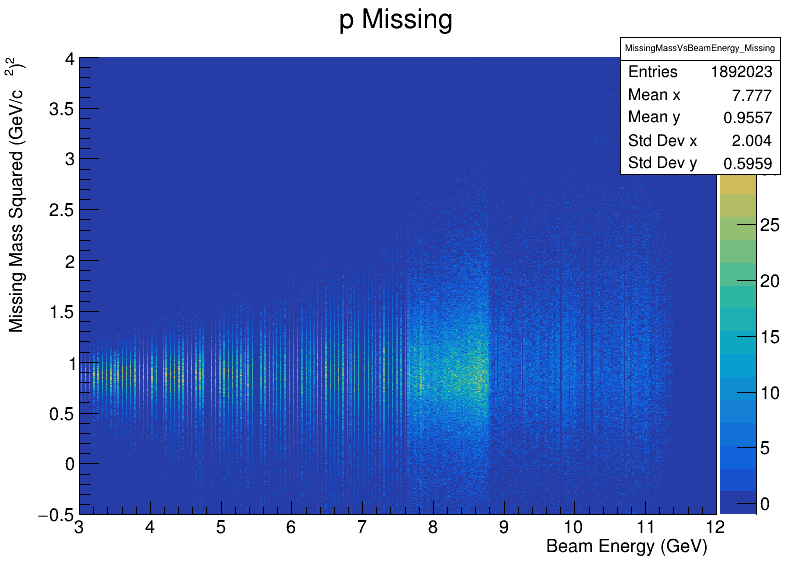

In [3]:
canv = ROOT.TCanvas("canv", "", 800, 600)
MM2vsBeamEnergyHists["Missing"].Draw("COLZ")
canv.Draw()

### Get missing overall mass squared distributions by projecting the 2D histograms and adjust binning

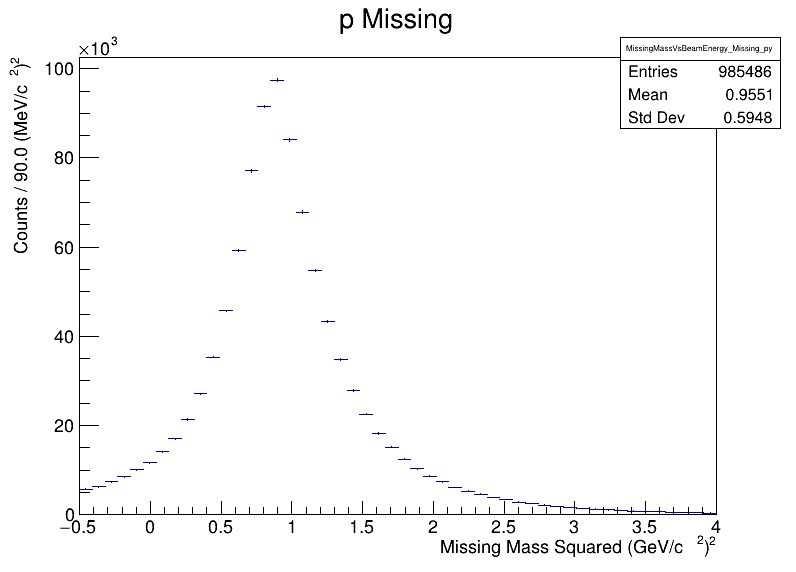

In [4]:
MM2Hists = {key : MM2vsBeamEnergyHist.ProjectionY() for (key, MM2vsBeamEnergyHist) in MM2vsBeamEnergyHists.items()}
for MM2Hist in MM2Hists.values():
  MM2Hist.Rebin(35)
  MM2Hist.SetYTitle(f"Counts / {MM2Hist.GetBinWidth(1) * 1000}" + " (MeV/c^{2})^{2}")
MM2Hists["Missing"].Draw()
canv.Draw()

## Fit overall missing mass squared distributions

### Function that fits a missing mass squared distribution with a double Gaussian on top of a 2nd-order polynomial

In [5]:
# define fit function
# see https://root-forum.cern.ch/t/syntax-of-a-free-function-or-c-functor-for-tgraph-fitting/22292/3
# and https://root.cern/manual/python/#just-in-time-compilation-of-small-strings
ROOT.gROOT.LoadMacro("./doubleGaussianPol2.C+")
# Python callables need to exits in scope where where fit functions are drawn
doubleGaussianPol2 = ROOT.doubleGaussianPol2()
signal = ROOT.doubleGaussianPol2(ROOT.doubleGaussianPol2.signal)
gaussian1 = ROOT.doubleGaussianPol2(ROOT.doubleGaussianPol2.gaussian1)
gaussian2 = ROOT.doubleGaussianPol2(ROOT.doubleGaussianPol2.gaussian2)
background = ROOT.doubleGaussianPol2(ROOT.doubleGaussianPol2.background)

# fit function to distribution
def fitMissingMassSquared(MM2Hist, fitRange = None, fixParValues = None, forceCommonGaussianMean = False):
  print(f"Fitting histogram '{MM2Hist.GetName()}', '{MM2Hist.GetTitle()}'")
  # construct fit function and set start parameters
  if fitRange is None:
    fitRange  = (MM2Hist.GetXaxis().GetXmin(), MM2Hist.GetXaxis().GetXmax())
  doubleGaussianPol2._forceCommonGaussianMean = forceCommonGaussianMean
  fitFunc = ROOT.TF1("doubleGaussianPol2", doubleGaussianPol2, fitRange[0], fitRange[1], 8 if forceCommonGaussianMean else 9)
  fitParameters = (("p_{0}", "p_{1}", "p_{2}", "A", "r", "#sigma_{1}", "#sigma_{2}", "#mu") if forceCommonGaussianMean
    else ("p_{0}", "p_{1}", "p_{2}", "A", "r", "#sigma_{1}", "#sigma_{2}", "#mu_{1}", "#mu_{2}"))
  fitFunc.SetParNames(*fitParameters)

  # first fitting stage: use single Gaussian
  fitFunc.SetParameter("A", math.sqrt(MM2Hist.Integral(MM2Hist.FindBin(fitRange[0]), MM2Hist.FindBin(fitRange[1]))))
  fitFunc.FixParameter(fitFunc.GetParNumber("r"), 0)
  if forceCommonGaussianMean:
    fitFunc.SetParameter("#mu", 0.938**2)
  else:
    fitFunc.SetParameter("#mu_{1}", 0.938**2)
    fitFunc.FixParameter(fitFunc.GetParNumber("#mu_{2}"), 0.938**2)
  fitFunc.SetParameter("#sigma_{1}", 1)
  fitFunc.SetParLimits(fitFunc.GetParNumber("#sigma_{1}"), 0, 10)
  fitFunc.FixParameter(fitFunc.GetParNumber("#sigma_{2}"), 1)
  fitFunc.SetParameter("p_{0}", 0)
  fitFunc.SetParameter("p_{1}", 0)
  fitFunc.SetParameter("p_{2}", 0)
  fitFunc.SetLineColor(ROOT.kRed + 1)
  fitFunc.SetNpx(1000)

  # ROOT.Math.MinimizerOptions().SetDefaultTolerance(0.001)
  # ROOT.Math.MinimizerOptions().SetMaxFunctionCalls(100000)
  # ROOT.Math.MinimizerOptions().SetDefaultPrintLevel(3)
  MM2Hist.Fit(fitFunc, "QRN")

  # second fitting stage: use double Gaussian
  fitFunc.ReleaseParameter(fitFunc.GetParNumber("r"))
  fitFunc.SetParameter("r", 0.3)  # nudge it, otherwise it does not move from zero
  fitFunc.ReleaseParameter(fitFunc.GetParNumber("#mu_{2}"))
  fitFunc.ReleaseParameter(fitFunc.GetParNumber("#sigma_{2}"))
  fitFunc.SetParLimits(fitFunc.GetParNumber("#sigma_{2}"), 0, 10)
  fitResult = MM2Hist.Fit(fitFunc, "REIMSN")
  MM2Hist.GetListOfFunctions().Add(fitFunc)
  fitResult.Print()
  print(f"reduced chi^2 = {fitResult.Chi2() / fitResult.Ndf()}; P-value = {fitResult.Prob()}")

  # add components of fit model to LoF of histogram
  signal._forceCommonGaussianMean = forceCommonGaussianMean
  sigFunc = ROOT.TF1("signal", signal, fitRange[0], fitRange[1], 9)
  sigFunc.SetLineColor(ROOT.kGreen + 2)
  gaussian1._forceCommonGaussianMean = forceCommonGaussianMean
  gauss1Func = ROOT.TF1("gaussian1", gaussian1, fitRange[0], fitRange[1], 9)
  gauss1Func.SetLineStyle(ROOT.kDashed)
  gauss1Func.SetLineColor(ROOT.kGreen + 2)
  gaussian2._forceCommonGaussianMean = forceCommonGaussianMean
  gauss2Func = ROOT.TF1("gaussian2", gaussian2, fitRange[0], fitRange[1], 9)
  gauss2Func.SetLineStyle(ROOT.kDashed)
  gauss2Func.SetLineColor(ROOT.kGreen + 2)
  background._forceCommonGaussianMean = forceCommonGaussianMean
  bgFunc = ROOT.TF1("background", background, fitRange[0], fitRange[1], 9)
  bgFunc.SetLineColor(ROOT.kBlue)
  components = (sigFunc, gauss1Func, gauss2Func, bgFunc)
  for func in components:
    func.SetNpx(1000)
    func.SetParNames(*fitParameters)
    func.SetParameters(fitFunc.GetParameters())
    MM2Hist.GetListOfFunctions().Add(func)

  print(gauss1Func.Integral(-10, 10), gauss2Func.Integral(-10, 10))

  return fitResult

### Fit missing mass squared distributions for the 3 cases

In [6]:
fitResults = {key : fitMissingMassSquared(MM2Hist, forceCommonGaussianMean = True) for (key, MM2Hist) in MM2Hists.items()}

Fitting histogram 'MissingMassVsBeamEnergy_py', 'p'
reduced chi^2 = 514.9823124305366; P-value = 0.0
99739.87550040956 117210.79235607332
Fitting histogram 'MissingMassVsBeamEnergy_Found_py', 'p Found'
reduced chi^2 = 308.92380463820587; P-value = 0.0
56520.62971513394 77230.27642607965
Fitting histogram 'MissingMassVsBeamEnergy_Missing_py', 'p Missing'
reduced chi^2 = 96.78520592477619; P-value = 0.0
44774.9836334477 42591.37029960083
 FCN=21629.3 FROM MINOS     STATUS=SUCCESSFUL     60 CALLS        2522 TOTAL
                     EDM=4.10393e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p_{0}       -4.18588e-05   8.85822e-01   1.30990e-05   6.65217e-07
   2  p_{1}       -8.08388e+01   6.00278e-01   1.52528e-03  -1.90357e-04
   3  p_{2}        1.26366e+01   1.61097e-01  -4.08677e-04  -1.21639e-04
   4  A           -4.65780e+02   2.74736

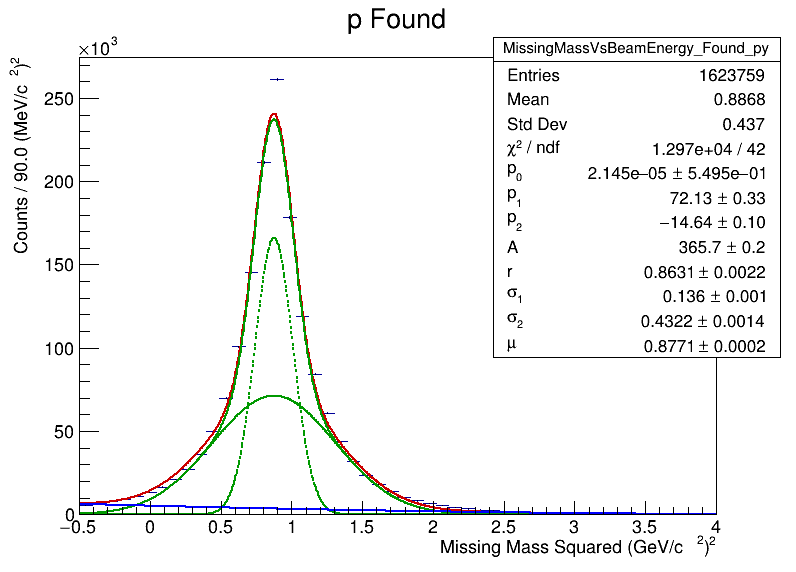

In [7]:
ROOT.gStyle.SetOptFit(True)
MM2Hists["Found"].Draw()
canv.Draw()

# Get signal yields and calculate overall efficiency

In [8]:
def getSignalYield(fitResult):
  signalYield = fitResult.Parameter(fitResult.Index("A"))**2
  return signalYield

In [9]:
# assumes that fitResuls is dictionary with TFitResults for "Total", "Found", and "Missing"
def calculateEfficiency(fitResults):
  signalYields = {key : getSignalYield(fitResult) for (key, fitResult) in fitResults.items()}
  print(signalYields, f"mismatch = {100 * (signalYields['Total'] - signalYields['Found'] - signalYields['Missing']) / signalYields['Total']}%")
  #TODO one could perform a combined fit of all 3 histograms enforcing Found + Missing == Total
  return signalYields["Found"] / (signalYields["Found"] + signalYields["Missing"])
print(f"Overall efficiency = {100 * calculateEfficiency(fitResults)}%")

{'Total': 216950.66785648285, 'Found': 133750.90614121358, 'Missing': 87366.35393304852} mismatch = -1.920525186184509%
Overall efficiency = 60.4886774086715%


## Fit missing mass squared distributions in bins of beam energy

In [10]:
def getMissingMassSquaredBeamEnergyBins(MM2vsBeamEnergyHist,
                                        nmbBeamEnergyBins = 9,          # 1 GeV bin width
                                        beamEnergyRange = (3.0, 12.0),  # [GeV]
                                        minCounts = 1000):              # minimum number of counts required in bin
  energyBinWidth = (beamEnergyRange[1] - beamEnergyRange[0]) / float(nmbBeamEnergyBins)
  MM2Hists = {}
  for energyBin in range(nmbBeamEnergyBins):
    # get distribution for given beam energy bin
    energyBinMin = beamEnergyRange[0] + energyBin * energyBinWidth
    energyBinMax = energyBinMin + energyBinWidth
    MM2Hist = MM2vsBeamEnergyHist.ProjectionY(f"{MM2vsBeamEnergyHist.GetName()}_py_{energyBin}",
      MM2vsBeamEnergyHist.GetXaxis().FindBin(energyBinMin),
      MM2vsBeamEnergyHist.GetXaxis().FindBin(energyBinMax))
    MM2Hist.Rebin(35)
    MM2Hist.SetTitle(f"{MM2vsBeamEnergyHist.GetTitle()}, {energyBinMin} < E_{{#gamma}} (GeV) < {energyBinMax}")
    MM2Hist.SetYTitle(f"Counts / {MM2Hist.GetBinWidth(1) * 1000} (MeV/c^{{2}})^{{2}}")
    counts = MM2Hist.Integral(1, MM2Hist.GetNbinsX())
    if  counts >= minCounts:
      MM2Hists[(energyBinMin, energyBinMax)] = MM2Hist
    else:
      print(f"Warning: {counts} counts in energy bin {(energyBinMin, energyBinMax)} are below the required minimum of {minCounts}. Skipping bin.")

  return MM2Hists

In [ ]:
MM2Hists = getMissingMassSquaredBeamEnergyBins(MM2vsBeamEnergyHist)

In [ ]:
def fitMissingMassSquaredBeamEnergyBins(MM2Hists):  # dictionary {energy bin : histogram}
  fitResults = {}
  for energyBin, MM2Hist in MM2Hists.items():
    # fit distribution
    print(f"Fitting beam energy bin {energyBin}")
    fitResults[energyBin] = fitMissingMassSquared(MM2Hist)

  return fitResults

In [ ]:
fitResults = fitMissingMassSquaredBeamEnergyBins(MM2Hists)

### Check whether fits converged

In [ ]:
COV_MATRIX_STATUS_CODE = {
  0 : "not calculated",
  1 : "approximated",
  2 : "made positive definite",
  3 : "accurate"
}
for energyBin, fitResult in fitResults.items():
  print(
    f"energy bin {energyBin}: "
    f"minimizer status = {fitResult.Status()}, "
    f"fit result is valid = {fitResult.IsValid()}, "
    f"covariance matrix status = {COV_MATRIX_STATUS_CODE[fitResult.CovMatrixStatus()]}"
  )

### Show fits

In [ ]:
canvs = []
for energyBin, MM2Hist in MM2Hists.items():
  canvs.append(ROOT.TCanvas(f"canv_{energyBin[0]}_{energyBin[1]}", "", 800, 600))
  MM2Hist.Draw()
  canvs[-1].Draw()

# Scratchpad

In [ ]:
# see https://root-forum.cern.ch/t/syntax-of-a-free-function-or-c-functor-for-tgraph-fitting/22292/3
# and https://root.cern/manual/python/#just-in-time-compilation-of-small-strings
ROOT.gInterpreter.ProcessLine('''
struct MyFunction {
  MyFunction() { }

  double operator() (double* vars, double* pars)
  {
    const double x  = vars[0];
    const double p0 = pars[0];
    const double p1 = pars[1];
    const double p2 = pars[2];

    const double linTerm = p1 + p2 * x;
    return p0 * p0 + linTerm * linTerm;
  }
};
''')
myFunc = ROOT.MyFunction()
func = ROOT.TF1("func", myFunc, -1, 1, 3)
# make function visible in Cling's global scope so it can be used in TFormula
# see https://root-forum.cern.ch/t/advanced-tformula-and-tf1-usage/36643/2
ROOT.gInterpreter.ProcessLine("TF1& func = *((TF1*)gROOT->GetFunction(\"func\"))")
#!!! parameter setting in TFormula expression does not work
fooFunc = ROOT.TF1("fooFunc", "func(x)", -1, 1, 3)
fooFunc.SetParameter(0, -1)
fooFunc.SetParameter(1, -2)
fooFunc.SetParameter(2, -3)
# fooFunc = ROOT.TF1("fooFunc", "func(x, [2..4])", -1, 1, 5)
# fooFunc.SetParameter(0, 10)
# fooFunc.SetParameter(1, -5)
# fooFunc.SetParameter(2, -1)
# fooFunc.SetParameter(3, -2)
# fooFunc.SetParameter(4, -3)
# canv = ROOT.TCanvas("canv", "", 800, 600)
fooFunc.Draw()
canv.Draw()